In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from tensorflow import einsum
from einops import rearrange
from einops.layers.tensorflow import Rearrange

import math
from inspect import isfunction

from functools import partial
from tqdm import tqdm

import numpy as np
import os
import cv2

from glob import glob

import time
from tensorflow.python.data.experimental import AUTOTUNE
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import imutils
import skimage
from skimage.metrics import structural_similarity
import time
from skimage import filters, img_as_ubyte,morphology,measure
from scipy.ndimage import label

In [2]:
########################ops#########################
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)

class EMA(Layer):
    def __init__(self, beta=0.995):
        super(EMA, self).__init__()
        self.beta = beta

    @tf.function
    def update_model_average(self, old_model, new_model):
        for old_weight, new_weight in zip(old_model.weights, new_model.weights):
            assert old_weight.shape == new_weight.shape

            old_weight.assign(self.update_average(old_weight, new_weight))

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02

    return tf.cast(tf.linspace(beta_start, beta_end, timesteps), tf.float32)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = tf.cast(tf.linspace(0, timesteps, steps), tf.float32)

    alphas_cumprod = tf.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    return tf.clip_by_value(betas, 0, 0.999)

def extract(x, t):
    return tf.gather(x, t)[:, None, None, None]

def Filter(image,model="BLUR"): #均值模糊
    if model == "conv2D":
        kernel = np.ones((3, 3)) / 9
        dst = cv2.filter2D(image, -1, kernel)
    if model == "BLUR":
        dst = cv2.blur(image, (10, 10))
    if model == "Guass":
        dst = cv2.GaussianBlur(image, (0, 0), 2)
    return dst

In [3]:
########################util#########################
class Image_data:

    def __init__(self, img_size, dataset_path):
        self.img_size = img_size
        self.dataset_path = dataset_path


    def image_processing(self, filename):

        x = tf.io.read_file(filename)
        x_decode = tf.image.decode_jpeg(x, channels=3, dct_method='INTEGER_ACCURATE')
        img = tf.image.resize(x_decode, [self.img_size, self.img_size], antialias=True, method=tf.image.ResizeMethod.BICUBIC)
        img = preprocess_fit_train_image(img)

        return img

    def preprocess(self):

        self.train_images = glob(os.path.join(self.dataset_path, '*.png')) + glob(os.path.join(self.dataset_path, '*.jpg'))

def adjust_dynamic_range(images, range_in, range_out, out_dtype):
    scale = (range_out[1] - range_out[0]) / (range_in[1] - range_in[0])
    bias = range_out[0] - range_in[0] * scale
    images = images * scale + bias
    images = tf.clip_by_value(images, range_out[0], range_out[1])
    images = tf.cast(images, dtype=out_dtype)
    return images

def random_flip_left_right(images):
    s = tf.shape(images)
    mask = tf.random.uniform([1, 1, 1], 0.0, 1.0)
    mask = tf.tile(mask, [s[0], s[1], s[2]]) # [h, w, c]
    images = tf.where(mask < 0.5, images, tf.reverse(images, axis=[1]))
    return images

def preprocess_fit_train_image(images):
    images = adjust_dynamic_range(images, range_in=(0.0, 255.0), range_out=(-1.0, 1.0), out_dtype=tf.dtypes.float32)
    images = random_flip_left_right(images)
    # images = tf.transpose(images, [2, 0, 1])

    return images

def preprocess_image(images):
    images = adjust_dynamic_range(images, range_in=(0.0, 255.0), range_out=(-1.0, 1.0), out_dtype=tf.dtypes.float32)
    # images = tf.transpose(images, [2, 0, 1])

    return images

def postprocess_images(images):
    images = adjust_dynamic_range(images, range_in=(-1.0, 1.0), range_out=(0.0, 255.0), out_dtype=tf.dtypes.float32)
    # images = tf.transpose(images, [0, 2, 3, 1])
    images = tf.cast(images, dtype=tf.dtypes.uint8)
    return images

def load_images(image_path, img_width, img_height, img_channel):

    # from PIL import Image
    if img_channel == 1 :
        img = cv2.imread(image_path, flags=cv2.IMREAD_GRAYSCALE)
    else :
        img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # img = cv2.resize(img, dsize=(img_width, img_height))
    img = tf.image.resize(img, [img_height, img_width], antialias=True, method=tf.image.ResizeMethod.BICUBIC)
    img = preprocess_image(img)

    if img_channel == 1 :
        img = np.expand_dims(img, axis=0)
        img = np.expand_dims(img, axis=-1)
    else :
        img = np.expand_dims(img, axis=0)

    return img

def save_images(images, size, image_path):
    # size = [height, width]
    return imsave(postprocess_images(images), size, image_path)

def imsave(images, size, path):
    images = merge(images, size)
    images = cv2.cvtColor(images.astype('uint8'), cv2.COLOR_RGB2BGR)

    return cv2.imwrite(path, images)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[h*j:h*(j+1), w*i:w*(i+1), :] = image

    return img

def str2bool(x):
    return x.lower() in ('true')

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

def multi_gpu_loss(x, global_batch_size):
    ndim = len(x.shape)
    no_batch_axis = list(range(1, ndim))
    x = tf.reduce_mean(x, axis=no_batch_axis)
    x = tf.reduce_sum(x) / global_batch_size

    return x

In [4]:
##########################layers############################
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05)
        self.act = SiLU() # x * sigmoid(x)

    def call(self, x, scale_shift=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            scale_shift = tf.split(time_emb, num_or_size_splits=2, axis=-1)

        h = self.block1(x, scale_shift=scale_shift, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            LayerNorm(dim)
        ])

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1)

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)

        return out

class MLP(Layer):
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()
        self.net = Sequential([
            Rearrange('... -> ... 1'), # expand_dims(axis=-1)
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

In [5]:
#######################network#####################################
class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        if sinusoidal_cond_mlp:
            self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ])
        else:
            self.time_mlp = MLP(time_dim)

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ])

    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

class GaussianDiffusion(Model): 
    def __init__(self, image_size, timesteps=200):
        super(GaussianDiffusion, self).__init__()
        self.timesteps = timesteps
        self.image_size = image_size
    def sample_timesteps(self, n, t_cut=None):
        if t_cut==None:
            sample_t = tf.random.uniform(shape=[n], minval=1, maxval=self.timesteps, dtype=tf.int32)
        else:
            sample_t = tf.random.uniform(shape=[n], minval=1, maxval=t_cut, dtype=tf.int32)
        return sample_t

    def noise_images(self, x, t, filtersize): # forward process q ##########正向disfussion过程###############
        xt =[]
        for batch in range(len(x)):
            tem_x = x[batch]
            tem_t= np.max(t[batch]) #随便取个值
            for i in range(tem_t):
                tem_x1 = tem_x
                tem_x = cv2.GaussianBlur(tem_x,(filtersize,filtersize),0,0)
            xt.append(tem_x) 
        xt = np.array(xt)
        return xt #t时刻噪声图

    def sample(self, model, n, start_x=None, start_t=None): # reverse process p ##########反向disfussion过程###############
        if start_x is None:
            x = tf.random.normal(shape=[n, self.image_size[0], self.image_size[1], 3]) 
        else:
            x = start_x

        for i in tqdm(reversed(range(1, self.timesteps if start_t is None else (start_t+1))), desc='sampling loop time step', total=self.timesteps):
            t = tf.ones(n, dtype=tf.int32) * i #从最后时刻倒着往前推
            x0_predicted =  model(x, t, training=False) ##U-Net输出预测原始图像
            x0_predicted = np.array(x0_predicted)
            Dt = self.noise_images(x0_predicted,t, filtersize =3)
            Dt_1 = self.noise_images(x0_predicted,tf.ones(n, dtype=tf.int32) * (i-1), filtersize =3)
            x = x -Dt+Dt_1
            #plt.imshow(x[0]/255.)
            #plt.show()

        return x

In [ ]:
automatic_gpu_usage()#分配GPU

##########加载数据#############
image_dir = r'F:\HCJ_for_AI_training\NTU\Nocrack_pavement_train' #(1024,2048,3)

def get_image_paths(image_dir:str):
    '''
    获取所有图片与对应标签的路径 
    '''
    # 导入数据集
    all_file=os.listdir(image_dir)
    all_image=[]
    for i in range(len(os.listdir(image_dir))):
        if os.path.splitext(all_file[i])[1] == ".jpg":
            all_image.append(image_dir + "\\" +  all_file[i])
    all_image=np.array(all_image)[:,np.newaxis]
    return all_image

paths = get_image_paths(image_dir)
#print(paths)
#paths_count = len(paths)
BATCH_SIZE = 2

#创建图片路径及其数字标签的dataset
db_train= tf.data.Dataset.from_tensor_slices(paths)
db_train = db_train.shuffle(buffer_size=100,seed=2023)
db_train = db_train.batch(BATCH_SIZE)

def load_image(path,resize="None"):
    path = str(path)[12:-26].replace("\\\\","/")
    image = cv2.imread(path)
    #resize
    image = cv2.resize(image,dsize=(2048,1024),interpolation=cv2.INTER_LINEAR) #小坑：宽度在前，高度在后,得到的size和desize的输入是颠倒的
    H = image.shape[0]
    W = image.shape[1]
    if resize=="Small":
        image = cv2.resize(image, (W//8,H//8), interpolation=cv2.INTER_AREA)  
        
    return image

def ssim_images(images1,images2,size=3):
    Score=[]
    for i in range (len(images1)):
        grayA = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(image2.astype(np.uint8), cv2.COLOR_BGR2GRAY)

        # 计算两个灰度图像之间的结构相似度
        (score, diff) = structural_similarity(grayA, grayB, win_size=size, full=True)
    Score.append(score)
    return np.average(Score)

""" Network """
unet = Unet()
diffusion = GaussianDiffusion((128, 256), timesteps=100)

""" Finalize model (build) """
test_images = np.ones([1, 128, 256, 3])
test_t = diffusion.sample_timesteps(n=test_images.shape[0])
_ = unet(test_images, test_t)

""" Optimizer """
optimizer = tf.keras.optimizers.Adam(1e-4)
unet.load_weights("./Diffusion-Unet-blur")

History=[]
filtersize=3
for epoch in range(0,1000,1):
    count=0
    db_train = db_train.shuffle(16)
    Average_loss=0
    for batch_size in db_train:
        count+=1
        train_image = []
        for i in range(len(batch_size)):
            train_image.append(load_image(batch_size[i][0],resize="Small"))
        train_image=np.array(train_image,dtype=float)

        with tf.GradientTape() as tape:
            t = diffusion.sample_timesteps(n=train_image.shape[0]) 
            x_t = diffusion.noise_images(train_image, t, filtersize) #t时刻噪声图
  
            predicted_noise_image = unet(x_t, t) #t-1时刻的噪声图
    
            #loss = tf.square(predicted_noise_image - x_t_1)
            #loss = multi_gpu_loss(loss, global_batch_size=BATCH_SIZE)
            loss = tf.keras.losses.mean_absolute_error(train_image,predicted_noise_image)
            loss = tf.reduce_mean(loss)
            
            gradients = tape.gradient(loss, unet.trainable_variables)
            optimizer.apply_gradients(zip(gradients, unet.trainable_variables))
            #tf.print("Loss:%4.2f" %(loss))   
            Average_loss=Average_loss + loss
        
    Average_loss = Average_loss/count
    History.append([epoch, Average_loss])
    tf.print("=>Epoch%4d  Averageloss:%4.2f" %(epoch, Average_loss))   

    unet.save_weights("./Diffusion-Unet-blur")

In [ ]:
history = np.array(History)
columns_list = ['Epoch','Loss']
df = pd.DataFrame(History, columns=columns_list)
df.to_excel("F://HCJ_for_AI_training//NTU//Diffusion_Epochs_blur.xlsx", index=False)

1 Physical GPUs, 1 Logical GPUs


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.26it/s]


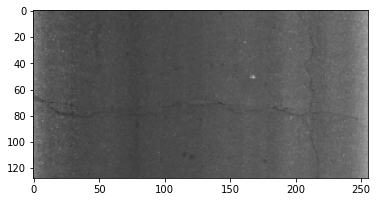

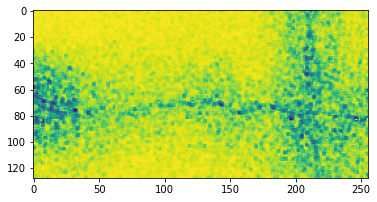

SSIM:0.8521133902678573


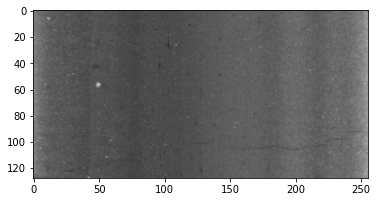

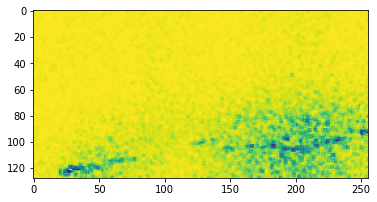

sampling loop time step:   1%|▌                                                        | 1/100 [00:00<00:12,  8.02it/s]

SSIM:0.9339423052140495


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.40it/s]


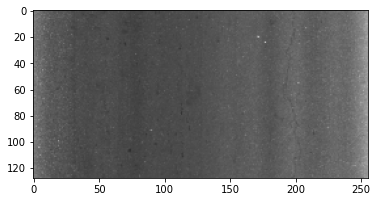

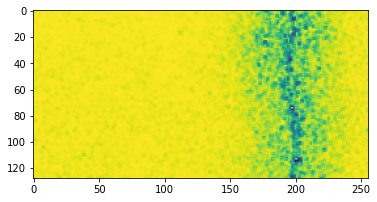

SSIM:0.9267380288692805


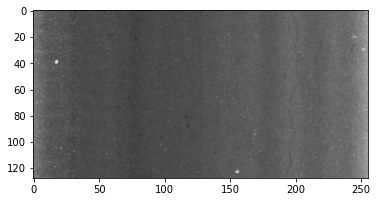

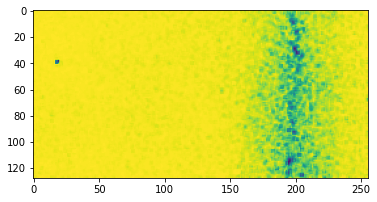

SSIM:0.9392553363973856


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.41it/s]


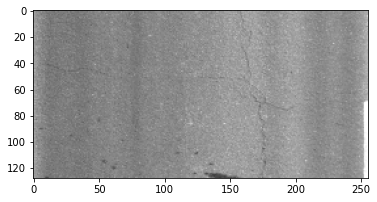

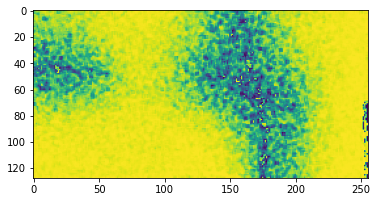

SSIM:0.823988607326764


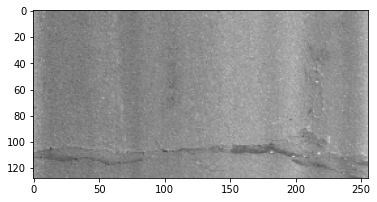

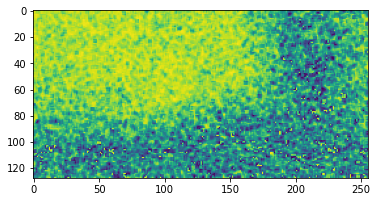

SSIM:0.647589384140149


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.39it/s]


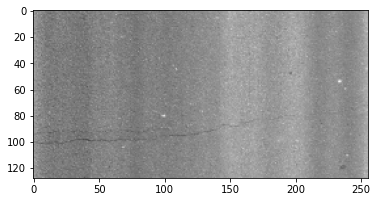

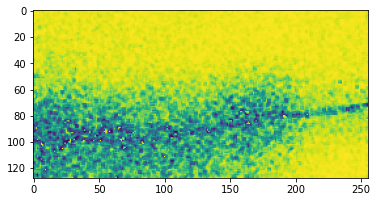

SSIM:0.8007190796964729


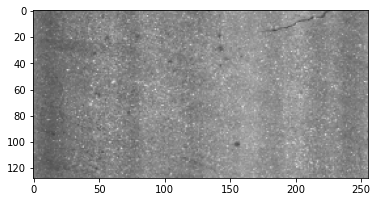

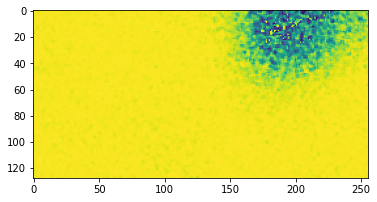

SSIM:0.9375723088244451


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.44it/s]


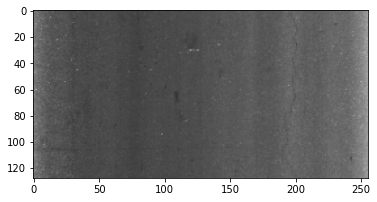

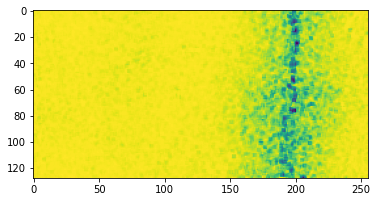

SSIM:0.9416993426157306


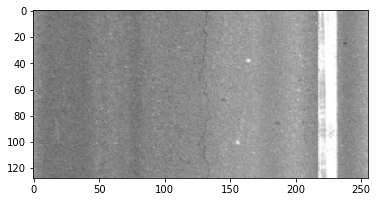

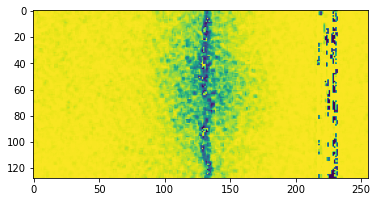

SSIM:0.9143276635460166


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.41it/s]


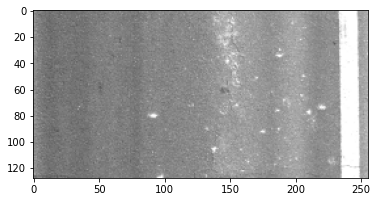

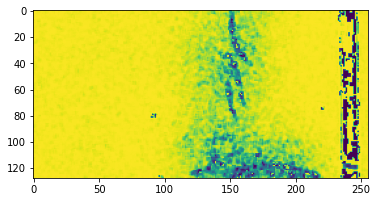

SSIM:0.8882356392538958


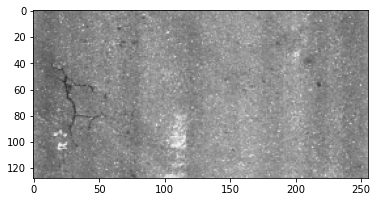

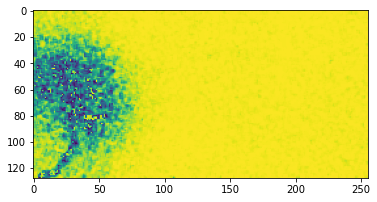

SSIM:0.8962256164589932


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.38it/s]


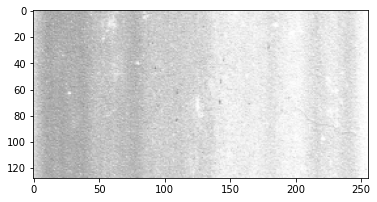

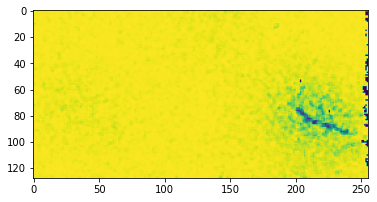

SSIM:0.9550723235837071


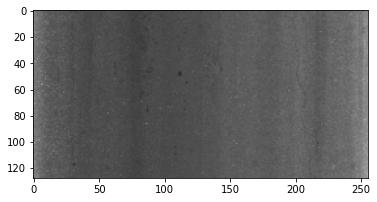

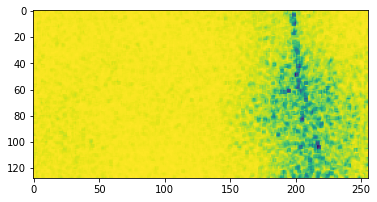

SSIM:0.9405138358734024


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.50it/s]


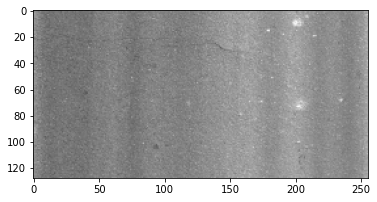

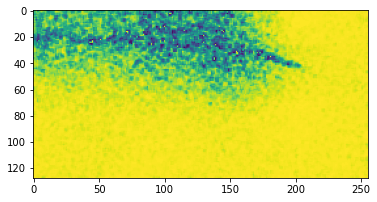

SSIM:0.8650363181412347


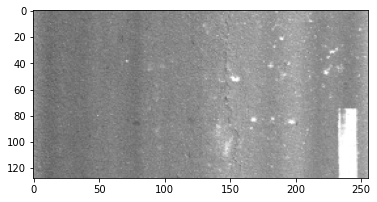

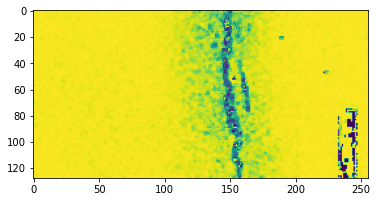

sampling loop time step:   1%|▌                                                        | 1/100 [00:00<00:12,  7.68it/s]

SSIM:0.9329261673430044


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.45it/s]


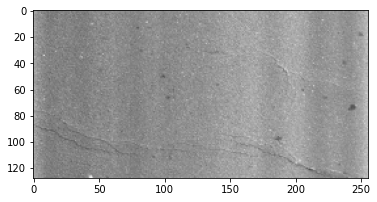

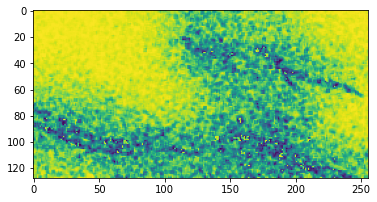

SSIM:0.7342458221277005


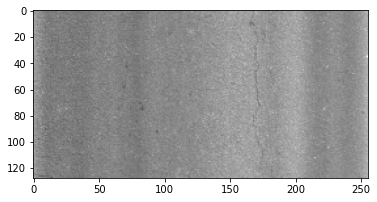

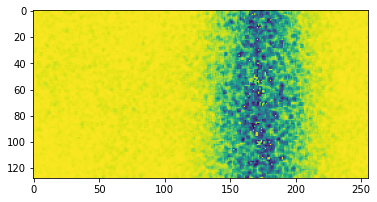

SSIM:0.8670606971707735


sampling loop time step:  80%|████████████████████████████████████████████▊           | 80/100 [00:09<00:02,  8.44it/s]


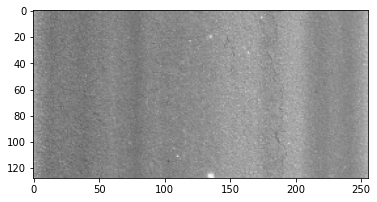

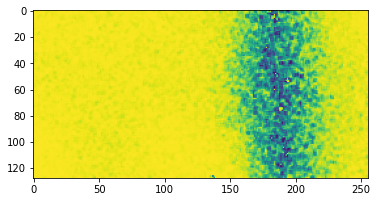

SSIM:0.8850610569351568


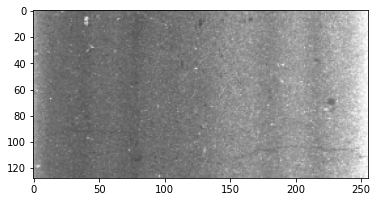

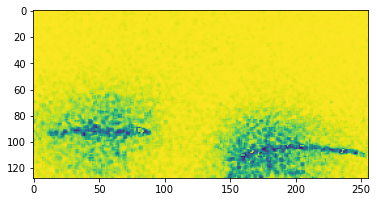

SSIM:0.919451727046377


In [10]:
automatic_gpu_usage()#分配GPU
###########sample##################
BATCH_SIZE = 2

""""""
##########加载数据#############
#image_dir = r'F:\HCJ_for_AI_training\NTU\Test' 
image_dir =r'F:\HCJ_for_AI_training\NTU\Test'
def get_image_paths(image_dir:str):
    '''
    获取所有图片与对应标签的路径 
    '''
    # 导入数据集
    all_file=os.listdir(image_dir)
    all_image=[]
    for i in range(len(os.listdir(image_dir))):
        if os.path.splitext(all_file[i])[1] == ".jpg":
            all_image.append(image_dir + "\\" +  all_file[i])
    all_image=np.array(all_image)[:,np.newaxis]
    return all_image


paths = get_image_paths(image_dir)
#print(paths)
#paths_count = len(paths)

#创建图片路径及其数字标签的dataset
db_train= tf.data.Dataset.from_tensor_slices(paths)
db_train = db_train.shuffle(buffer_size=100,seed=2023)
db_train = db_train.batch(BATCH_SIZE)
def load_image(path,resize="None"):
    path = str(path)[12:-26].replace("\\\\","/")
    image = cv2.imread(path)
    image = cv2.resize(image,dsize=(2048,1024),interpolation=cv2.INTER_LINEAR) #小坑：宽度在前，高度在后,得到的size和desize的输入是颠倒的
    H = image.shape[0]
    W = image.shape[1]
    if resize=="Small":
        image = cv2.resize(image, (W//8,H//8), interpolation=cv2.INTER_AREA)  
        
    return image

def ssim(image1,image2,size=3):
    grayA = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(image2.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # 计算两个灰度图像之间的结构相似度
    (score, diff) = structural_similarity(grayA, grayB, win_size=size, full=True)
    diff = (diff * 255).astype("uint8")
    return diff,score

def ssim_new(image1,image2,size=3):
    h,w,d = np.array(image1).shape
    grayA = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(image2.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    new_image=np.zeros(np.array(grayA).shape)
    for i in range(h-size):
        for j in range(w-size):
            tem_A = grayA[i:i+size,j:j+size]
            tem_B = grayB[i:i+size,j:j+size]
            (score,_) = structural_similarity(tem_A, tem_B, win_size=size,  full=True)
            new_image[i+int(size/2),j+int(size/2)]=1-score
    new_image = np.array(new_image)   
    return new_image

#自适应阈值
def adaptiveThresh(I):
    tem=[]
    for i in range(255):
        tem.append(np.sum(np.where(I==i,1,0)))
    count=0
    value=0
    for j in range(len(tem)):
        if count <int(128*256*0.05):
            count+=tem[j]
        else:
            value = j
            break
    out= np.clip(I,value-1,value)
    return out

""" Network """
unet = Unet()
diffusion = GaussianDiffusion((128, 256), timesteps=100)

""" Finalize model (build) """
test_images = np.ones([1, 128, 256, 3])
test_t = diffusion.sample_timesteps(n=test_images.shape[0])
_ = unet(test_images, test_t)

"""Add weights"""
unet.load_weights("./Diffusion-Unet-blur")

count=0

for batch_size in db_train:
    count+=1
    train_image = []
    for i in range(len(batch_size)):
        train_image.append(load_image(batch_size[i][0],resize="Small"))

    train_image = np.array(train_image).astype('float')
    """
    plt.imshow(train_image[0]/255)
    plt.show()
    for i in range(5):
        noise_image = diffusion.noise_images(x=train_image, t=tf.ones(BATCH_SIZE, dtype=tf.int32) * (i+2)*5, filtersize =3)
        plt.imshow(noise_image[0]/255.)
        plt.show()
    """  
    noise_image = diffusion.noise_images(x=train_image, t=tf.ones(BATCH_SIZE, dtype=tf.int32) * 80, filtersize =3)
    Generator_image = diffusion.sample(unet,BATCH_SIZE,noise_image,80)
    #plt.imshow(Generator_image[0]/255.)
    #plt.show()
    for i in range(BATCH_SIZE):
        plt.imshow(train_image[i]/255)
        plt.show()
        diff,score = ssim(train_image[i],Generator_image[i],size=3)
        plt.imshow(diff)
        plt.show()
        print("SSIM:{}".format(score))
        #diff_new =  ssim_new(train_image[i],Generator_image[i],size=5)
        #plt.imshow(diff_new)
        #plt.show()
        #print(diff_new)

        #diff_noise = adaptiveThresh(diff)
        #plt.imshow(diff_noise)
        #plt.show()
    if count==10:
        break

In [ ]:
import imutils
from skimage.metrics import structural_similarity
import time
from skimage import filters, img_as_ubyte,morphology,measure
from scipy.ndimage import label

#自适应阈值
def adaptiveThresh(I, winSize, ratio=0.10):
    # 第一步:对图像矩阵进行均值平滑
    I_mean = cv2.boxFilter(I, cv2.CV_32FC1, winSize)

    # 第二步:原图像矩阵与平滑结果做差
    out = I - (1.0 - ratio) * I_mean

    # 第三步:当差值大于或等于0时，输出值为255；反之，输出值为0
    out[out >= 0] = 255
    out[out < 0] = 0
    out = out.astype(np.uint8)
    out = np.abs(out-255)
    
    #去除离散点
    p=np.argwhere(out>0)
    x_low=int(np.percentile(p[:,0],5,axis=0))
    x_up=int(np.percentile(p[:,0],95,axis=0))
    y_low=int(np.percentile(p[:,1],5,axis=0))
    y_up=int(np.percentile(p[:,1],95,axis=0))
    out[0:x_low,:]=0
    out[x_up:,:]=0
    out[:,0:y_low]=0
    out[:,y_up:]=0
    return out

for i in range(BATCH_SIZE):
    plt.imshow(train_image[i]/255)
    plt.show()
    grayA = cv2.cvtColor((Generator_image[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor((train_image[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # 计算两个灰度图像之间的结构相似度
    (score, diff) = structural_similarity(grayA, grayB, win_size=3, full=True)
    diff = (diff * 255).astype("uint8")
    #cv2.namedWindow("diff", cv2.WINDOW_NORMAL)
    #cv2.imshow("diff", diff)
    plt.imshow(diff)
    plt.show()
    print("SSIM:{}".format(score))

    diff_noise = adaptiveThresh(diff,(5,5))
    plt.imshow(diff_noise)
    plt.show()
